In [11]:
#Importing all the necessary modules.
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
from itertools import chain
from tqdm import tqdm


In [12]:
train_dir = 'D:/osic-pulmonary-fibrosis-progression/train/'
working_path = 'D:/osic-pulmonary-fibrosis-progression/Dicom_Analysis_Part_2/working_path/'
train_patient_ids=[]
files = []
for root,dirs,filenames in os.walk(train_dir):
    train_patient_ids.extend(dirs)
for i in train_patient_ids:
    path = train_dir + i
    files.append([train_dir + i for i in os.listdir(path)])
#files is a 2-d list holding the exact path of the dicom files. This will be used to understand the hound values.

In [13]:
#Displaying Houndfeld Units

files_1d = list(chain.from_iterable(files)) #Flattening of list.
#print(len(files_1d)) 

In [14]:
#      
# Loop over the image files and store everything into a list.
# 
BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618'] #Bad Encoding
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618'] #Bad Encoding

image_data = []
for patient_id in tqdm(train_patient_ids[10:11]):
    if patient_id  in BAD_ID:
        continue
    path = train_dir + patient_id   
    #Adding metadata Slice Thickness to all the slices
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber)) 
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = slices[0].SliceThickness
    for s in slices:
        s.SliceThickness = slice_thickness
    imgs = get_pixels_hu(slices)
    image_data.append(imgs)

100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


In [15]:
imgs_to_process = np.array(image_data)

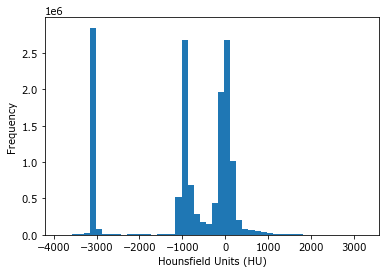

In [16]:
plt.hist(imgs_to_process.flatten(), bins=50)
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

### As we can see there are a lot of entities present in the lungs, we may need to remove them.